In [ ]:
import pandas as pd
import numpy as np
from itertools import chain
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import nltk.stem.porter 
from nltk.stem.porter import *
import string
from nltk import ConfusionMatrix
from itertools import chain
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
'''
Reading data into data frame
'''
df_train = pd.read_csv('train.txt', sep=" ",header=None)
df_test = pd.read_csv('test.txt', sep=" ",header=None)

In [ ]:
'''
Initial pre-processing
'''
df_train[2] = df_train[2].str.split("-", n = 1, expand = True) 
df_test[2]  = df_test[2].str.split("-", n = 1, expand = True)

In [ ]:
'''
Reading data into data frame
'''
df_train = pd.read_csv('train.txt', sep=" ",header=None,skip_blank_lines=False, names=['word','POS_tag','Chunk_tag'])
df_test = pd.read_csv('test.txt', sep=" ",header=None,skip_blank_lines=False, names=['word','POS_tag','Chunk_tag'])

In [ ]:
'''
Initial pre-processing
'''
df_train['Chunk_tag'] = df_train['Chunk_tag'].str.split("-", n = 1, expand = True) 
df_test['Chunk_tag']  = df_test['Chunk_tag'].str.split("-", n = 1, expand = True) 

In [ ]:
'''
Adding extra row for train sentences for ease of processing
'''
df_train = pd.concat([pd.DataFrame([['EOS','EOS','O']],columns=df_train.columns),df_train],ignore_index=True)


'''
Adding extra row for train sentences for ease of processing
'''
df_test = pd.concat([pd.DataFrame([['EOS','EOS','O']],columns=df_test.columns),df_test],ignore_index=True)

In [ ]:
'''
Utility functions
'''
stemmer = PorterStemmer()

def return_affix(word):
    word = word.lower()
    stem_word = stemmer.stem(word)          
    affix=word.split(stem_word)[-1]
    return affix

def is_capitalised(word):
    return word[0].upper() == word[0]

def all_capital(word):
    return word.upper() == word

def all_lower(word):
    return word.lower() == word

In [ ]:
'''
Generating features for CRF
'''

df_train['prev_POS']= df_train['POS_tag'].shift(1)
df_train['prev_prev_POS']= df_train['POS_tag'].shift(2)
df_train['prev_word']= df_train['word'].shift(1)
df_train['next_word'] = df_train['word'].shift(-1)
df_train['next_POS']= df_train['POS_tag'].shift(-1)
df_train['next_next_POS']= df_train['POS_tag'].shift(-2)
df_train['Chunk_tag'] = df_train['Chunk_tag'].fillna('O')
df_train['is_lower'] = (df_train['word'].str).islower()
df_train = df_train.fillna('EOS')

df_train['stemmed_word'] = df_train['word'].apply(stemmer.stem)
df_train['all_capital'] = df_train['word'].apply(all_capital)
df_train['all_lower'] = df_train['word'].apply(all_lower)
df_train['is_Capitalised'] = df_train['word'].apply(is_capitalised)
df_train['word_affix'] = df_train['word'].apply(return_affix)


In [ ]:
'''
Seggregating train data into X and Y
'''

df_X_train = df_train.drop(columns='Chunk_tag')
df_Y_train = df_train['Chunk_tag']

In [ ]:
dict_X =df_X_train.to_dict('records')
dict_X = [[i] for i in dict_X]
print(len(dict_X))
print(dict_X[0])

220664
[{'word': 'EOS', 'POS_tag': 'EOS', 'prev_POS': 'EOS', 'prev_prev_POS': 'EOS', 'prev_word': 'EOS', 'next_word': 'Confidence', 'next_POS': 'NN', 'next_next_POS': 'IN', 'is_lower': False, 'stemmed_word': 'eo', 'all_capital': True, 'all_lower': False, 'is_Capitalised': True, 'word_affix': 's'}]


In [ ]:
'''
CRF Training
'''
Y_train = [[label] for label in df_train['Chunk_tag']]
print(len(Y_train))
print(Y_train[0:2])
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=1000,
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=['B', 'I', 'O'])

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(dict_X, Y_train)

#crf.fit(dict_X, Y_train)


220664
[['O'], ['B']]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 75.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 101.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201E8324278>, 'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201830CD128>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(flat_f1_score, average=weighted, labels=['B', 'I', 'O']),
          verbose=1)

In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.6974565434489933, 'c2': 0.04899556712152492}
best CV score: 0.9500828912681624
model size: 0.83M


In [ ]:
'''
Generating features for CRF
'''

df_test['prev_POS']= df_test['POS_tag'].shift(1)
df_test['prev_prev_POS']= df_test['POS_tag'].shift(2)
df_test['prev_word']= df_test['word'].shift(1)
df_test['next_word'] = df_test['word'].shift(-1)
df_test['next_POS']= df_test['POS_tag'].shift(-1)
df_test['next_next_POS']= df_test['POS_tag'].shift(-2)
df_test['Chunk_tag'] = df_test['Chunk_tag'].fillna('O')
df_test['is_lower'] = (df_test['word'].str).islower()
df_test = df_test.fillna('EOS')
df_test['stemmed_word'] = df_test['word'].apply(stemmer.stem)
df_test['all_capital'] = df_test['word'].apply(all_capital)
df_test['all_lower'] = df_test['word'].apply(all_lower)
df_test['is_Capitalised'] = df_test['word'].apply(is_capitalised)
df_test['word_affix'] = df_test['word'].apply(return_affix)
df_test = df_test.fillna('EOS')

In [ ]:
df_X_test = df_test.drop(columns='Chunk_tag')
df_Y_test = df_test['Chunk_tag']
print(df_Y_test)

0        O
1        B
2        I
3        I
4        B
        ..
49385    B
49386    B
49387    I
49388    O
49389    O
Name: Chunk_tag, Length: 49390, dtype: object


In [ ]:
dict_X_test =df_X_test.to_dict('records')
dict_X_test = [[i] for i in dict_X_test]
print(len(dict_X_test))
print(dict_X_test[0])

49390
[{'word': 'EOS', 'POS_tag': 'EOS', 'prev_POS': 'EOS', 'prev_prev_POS': 'EOS', 'prev_word': 'EOS', 'next_word': 'Rockwell', 'next_POS': 'NNP', 'next_next_POS': 'NNP', 'is_lower': False, 'stemmed_word': 'eo', 'all_capital': True, 'all_lower': False, 'is_Capitalised': True, 'word_affix': 's'}]


In [ ]:
'''
Make predictions
'''
Y_test = [[i] for i in df_Y_test]
crf = rs.best_estimator_
y_pred = crf.predict(dict_X_test)

In [ ]:
'''
F1 score
'''
metrics.flat_f1_score(Y_test, y_pred,
                      average='weighted', labels=['B', 'I', 'O'])

0.9520377871280409

In [ ]:
'''
Calculating precision,recall and f1-score for each individual tag
'''
sorted_labels = sorted(
    ['B','I','O'],
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    Y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           B      0.960     0.957     0.959     23852
           I      0.936     0.937     0.937     17345
           O      0.963     0.968     0.966      8193

   micro avg      0.952     0.952     0.952     49390
   macro avg      0.953     0.954     0.954     49390
weighted avg      0.952     0.952     0.952     49390



[[22831   955    66]
 [  849 16258   238]
 [  102   159  7932]]
AxesSubplot(0.125,0.125;0.62x0.755)


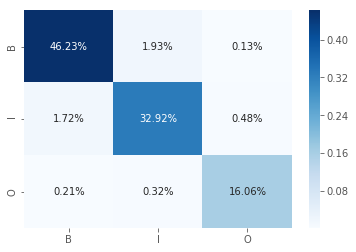

In [ ]:
'''
Printing confusion matrix
'''
cf_matrix = confusion_matrix(list(chain.from_iterable(Y_test)) ,list(chain.from_iterable(y_pred)))
print(cf_matrix)
print(sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=['B', 'I','O'], yticklabels=['B','I','O'], 
            fmt='.2%', cmap='Blues'))


AxesSubplot(0.125,0.125;0.62x0.755)


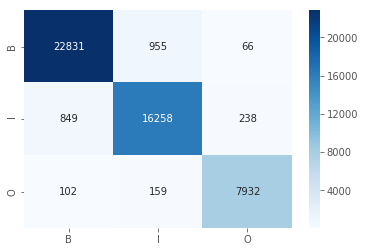

In [ ]:
print(sns.heatmap(cf_matrix, annot=True,xticklabels=['B', 'I','O'], yticklabels=['B','I','O'], 
            fmt="d", cmap='Blues'))

In [ ]:
'''
Overall Accuracy Calculation
'''
d ={'B':{'TP':0, 'FP':0, 'TN':0}, 'I':{'TP':0, 'FP':0, 'TN':0}, 'O':{'TP':0, 'FP':0, 'TN':0}}

TP=0
TN=0
for i in range(len(Y_test)):
    if(Y_test[i][0]==y_pred[i][0]):
        d[Y_test[i][0]]['TP']+=1
    else:
        d[Y_test[i][0]]['TN']+=1
        d[y_pred[i][0]]['FP']+=1
        
print(d) 

TP = 0
FP = 0

for tag in d.keys():
    if (tag !='O'):
        TP += d[tag]['TP']
        FP += d[tag]['FP']
        
acc = TP/(TP+FP)
print("Overall Accuracy", acc)
        


{'B': {'TP': 22831, 'FP': 951, 'TN': 1021}, 'I': {'TP': 16258, 'FP': 1114, 'TN': 1087}, 'O': {'TP': 7932, 'FP': 304, 'TN': 261}}
Overall Accuracy 0.9498226174855421
